In [1]:
#Import relevant APIs
import numpy as np
import pandas as pd
import tweepy as tw
import yfinance as yf
import sys
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import date
from datetime import timedelta
from sklearn.linear_model import LinearRegression

Setting up Twitter Authentication:

In [2]:
from tweepy import OAuthHandler
from tweepy import API

apiKey = 'sUY1UAhfmauoDAqodxPJCmE1d'
apiSecret = 'nRrYuBn8X1MauIFfyznAXdwdLsTcVReytlIUpsfjiI2GncodX0'
accessToken = '3295318197-LMzVBdXwZPbIgJU8Fd0ksjT8mEOES2HRYC2J2ha'
accessSecret = 'RgqkfaXowXGk1JaKs0jTOIvGVjZbGnL32bsPk4DuzohBf'

auth = OAuthHandler(apiKey, apiSecret)
auth.set_access_token(accessToken, accessSecret)
api = API(auth, wait_on_rate_limit = True)

Getting Ticker data and storing in Pandas DataFrame, then dict with only percent change:

In [3]:
tickers = ['TSLA','AAPL', 'FB', 'ZM']
perChange = {}

def storePercentChange():
    global end_date
    global days_prior
    global start_date
    end_date = date.today()
    days_prior = input("Enter the number of days to retrieve market data (max 7 days, min 2 days):  ")
    start_date = end_date - timedelta(days=int(days_prior))
    weekno = start_date.weekday()
    if weekno < 5 and int(days_prior) <= 7 and int(days_prior) >= 2:
        stock_data = yf.download(tickers, start=start_date, end=end_date, progress=False, group_by='ticker')
        for tick in tickers:
            percent_change = (((stock_data[tick]['Close'])[-1] - (stock_data[tick]['Close'])[str(start_date)])/
                (stock_data[tick]['Close'])[str(start_date)])*100
            perChange[tick] = round(abs(percent_change), 2)
    elif weekno >=5:
        sys.exit("Input leads to a date on the weekend. Exiting...")
    elif int(days_prior) > 7 or int(days_prior) < 2:
        sys.exit("Input does not match constraints. Exiting...")

Searching Twitter tweets using Tweepy:

In [4]:
tweetsDict = {}

def searchTweets():
    public_tweets = []
    count = 0
    counter = 0
    maxID = 0
    for tick in tickers:
        while counter < 10:
            if maxID > 0:
                public_tweets = api.search(q = '$'+tick+' -filter:retweets', count = 100, 
                                           since = start_date, until = end_date, max_id = maxID)
            else:
                public_tweets = api.search(q = '$'+tick+' -filter:retweets', count = 100, 
                                           since = start_date, until = end_date)
            count += len(public_tweets)
            maxID = public_tweets[-1].id
            counter += 1
        tweetsDict[tick] = count - 9 #Account for replicate tweets from using maxID
        counter = 0
        count = 0
        maxID = 0

Merging two dicts on Ticker axis, storing in DF and Plotting:

In [5]:
def mergeAndPlot():
    corr_list = [perChange, tweetsDict]
    correlation = {}

    for tick in perChange.keys():
        correlation[tick] = tuple(correlation[tick] for correlation in corr_list)
    
    initial_table = pd.DataFrame(correlation)
    final_table = initial_table.transpose()
    final_table.columns = ['% Change', 'Number of Tweets']
    print(final_table)
    final_table.plot(kind = 'scatter', x='Number of Tweets', y='% Change', title = 'Tweets vs. % Change')
    

Enter the number of days to retrieve market data (max 7 days, min 2 days):   4


      % Change  Number of Tweets
TSLA      2.05             936.0
AAPL      0.48             934.0
FB        0.81             939.0
ZM        6.29             966.0


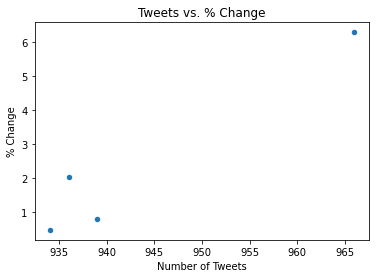

In [6]:
storePercentChange()
searchTweets()
mergeAndPlot()